In [1]:
from pathlib import Path
import pandas as pd
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
import numpy as np
import itertools
import random

from keras.preprocessing.sequence import pad_sequences

from transformers import BertTokenizer
from transformers import BertModel, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from transformers import DistilBertModel, AdamW
from transformers import BertForSequenceClassification

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pandarallel import pandarallel
pandarallel.initialize()

import os
os.chdir('..')

from src.data_lexical import LexDataset, read_lexical_corpus
from src.data_disambiguation import DisDataset, read_disambiguation_corpus
from src.model import BertForSharedTaskBaseline
from src.training import train, evaluate, forward_func_custom_bert

Using TensorFlow backend.


INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
import math
import os
import warnings
from dataclasses import dataclass
from typing import Optional, Tuple

import torch
import torch.utils.checkpoint
from torch import nn
from torch.nn import CrossEntropyLoss, MSELoss
from transformers import BertPreTrainedModel, BertModel
from transformers.modeling_outputs import SequenceClassifierOutput


class BertForSharedTaskMultitask(BertPreTrainedModel):

    _keys_to_ignore_on_load_unexpected = [r"pooler"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels_first_task = 1 # Regression
        self.num_labels_second_task = config.num_labels # Word sense disambiguation

        self.bert = BertModel(config)
        self.dropout_first = nn.Dropout(config.hidden_dropout_prob)
        self.dropout_second = nn.Dropout(config.hidden_dropout_prob)
        
        self.classifier_first = nn.Linear(config.hidden_size, self.num_labels_first_task)
        self.classifier_second = nn.Linear(config.hidden_size, self.num_labels_second_task)

        self.init_weights()
        

    def forward(
        self,
        input_ids=None,
        target_positions=None,
        task_id=1,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Labels for computing the token classification loss. Indices should be in ``[0, ..., config.num_labels -
            1]``.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        if task_id == 1:
            pooled_output = outputs[0][torch.arange(outputs[0].size(0)), target_positions]
            pooled_output = self.dropout_first(pooled_output)
            logits = self.classifier_first(pooled_output)

            loss = None
            if labels is not None:
                if self.num_labels_first_task == 1:
                    #  We are doing regression
                    loss_fct = MSELoss()
                    loss = loss_fct(logits.view(-1), labels.view(-1))
                else:
                    loss_fct = CrossEntropyLoss()
                    loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

            if not return_dict:
                output = (logits,) + outputs[2:]
                return ((loss,) + output) if loss is not None else output

            return SequenceClassifierOutput(
                loss=loss,
                logits=logits,
                hidden_states=outputs.hidden_states,
                attentions=outputs.attentions,
            )
        elif task_id == 2:
            sequence_output = outputs[0]

            sequence_output = self.dropout_second(sequence_output)
            logits = self.classifier_second(sequence_output)

            loss = None
            if labels is not None:
                loss_fct = CrossEntropyLoss()
                # Only keep active parts of the loss
                if attention_mask is not None:
                    active_loss = attention_mask.view(-1) == 1
                    active_logits = logits.view(-1, self.num_labels_second_task)
                    active_labels = torch.where(
                        active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
                    )
                    loss = loss_fct(active_logits, active_labels)
                else:
                    loss = loss_fct(logits.view(-1, self.num_labels_second_task), labels.view(-1))

            if not return_dict:
                output = (logits,) + outputs[2:]
                return ((loss,) + output) if loss is not None else output

            return TokenClassifierOutput(
                loss=loss,
                logits=logits,
                hidden_states=outputs.hidden_states,
                attentions=outputs.attentions,
            )


In [3]:
def forward_func_multitask_bert(batch, device, model, additional_params):

    # Clear gradients
    model.zero_grad()      
    b_input_ids = batch['input_ids'].to(device)
    b_input_mask = batch['attention_mask'].to(device)
        
    if additional_params['task_id'] == 1:
        b_labels = batch['labels'].to(device)
        b_positions =  batch['target_positions'].to(device)
      
        loss, logits = model(b_input_ids, 
                             b_positions,
                             task_id=1,
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
    elif additional_params['task_id'] == 2:
        b_labels = batch['labels'].to(device)

        loss, logits = model(b_input_ids, 
                             task_id=2,
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
    return loss, logits

In [4]:
epochs = 20
seed_val = 2
results_window = {}
max_len = 25
stop_at = 5
cuda_card = 0

In [5]:
data_sent_dis, data_senses_dis = read_disambiguation_corpus(max_len=max_len)

In [11]:
len(data_sent_dis)

9350

In [7]:
tag_values = list(set(list(itertools.chain(*data_senses_dis))))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [8]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [9]:
train_encodings_dis = tokenizer(list(data_sent_dis), truncation=True, padding=True, max_length=max_len)

data_tags_dis = pad_sequences([[tag2idx.get(l) for l in lab] for lab in data_senses_dis],
                     maxlen=max_len, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
train_dataset_dis = DisDataset(train_encodings_dis, data_tags_dis)

train_loader_dis = DataLoader(train_dataset_dis, batch_size=32)

In [10]:
import random
import numpy as np
from transformers import get_linear_schedule_with_warmup

for window_x in [0, 1, 2]:
    print('Window size of ', window_x)
    data_texts, data_corpus, data_labels, sentence_raw, target_words, positions = read_lexical_corpus('data/raw/lcp_single_train.tsv',
                                                                           return_complete_sent=False,
                                                                           window_size=window_x + 1)
    
    test_texts, _, test_labels, sentences_test, test_target_words, test_positions = read_lexical_corpus('data/raw/lcp_single_trial.xlsx',
                                                                           return_complete_sent=False,
                                                                           window_size=window_x + 1)
    
    torch.cuda.manual_seed_all(seed_val)
    
    train_index, val_index = train_test_split(list(range(0, len(data_texts))), test_size=0.12, random_state=10, shuffle=True)
    train_index, val_index = np.array(train_index), np.array(val_index)

    history_preds_val = []
    history_preds_test = []
    history_samples_val = []
    history_samples_test = []
    history_input = []
    history_input_test = []
    history_target = []
    history_target_test = []
    history_index = []
    history_index_test = []
    history_labels_val = []
    history_labels_test = []
    history_occur_text = []
    history_occur_target = []
    ix_fold = 0

    train_texts_lex, train_labels_lex, train_positions_lex, train_target_words_lex = data_texts[train_index], data_labels[train_index], positions[train_index], target_words[train_index]
    val_texts_lex, val_labels_lex, val_positions_lex, val_target_words_lex = data_texts[val_index], data_labels[val_index], positions[val_index], target_words[val_index]
        
    train_encodings_lex = tokenizer(list(train_texts_lex), truncation=True, padding=True)
    train_dataset_lex = LexDataset(train_encodings_lex, train_labels_lex, train_positions_lex)
    train_loader_lex = DataLoader(train_dataset_lex, batch_size=16)

    val_encodings = tokenizer(list(val_texts_lex), truncation=True, padding=True)
    val_dataset = LexDataset(val_encodings, val_labels_lex, val_positions_lex)
    val_loader = DataLoader(val_dataset, batch_size=1)

    test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)
    test_dataset = LexDataset(test_encodings, test_labels, test_positions)
    test_loader = DataLoader(test_dataset, batch_size=1)
        
    all_text = ' '.join(train_texts_lex)
    occurence_text = [all_text.count(w) for w in val_target_words_lex]
    
    occurence_target = [train_target_words_lex.tolist().count(w) for w in val_target_words_lex]
        
    device = torch.device(f"cuda:{cuda_card}")
        
    model = BertForSharedTaskMultitask.from_pretrained(
        "bert-base-uncased", 
        num_labels = len(tag2idx), 
        output_attentions = False, 
        output_hidden_states = False, 
    )
    model.cuda(cuda_card)

    optimizer_lex = AdamW(model.parameters(),
                          lr = 2e-5, 
                          eps = 1e-8
                        )

    total_steps = len(train_loader_lex) * epochs
    scheduler_lex = get_linear_schedule_with_warmup(optimizer_lex, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)
        
    optimizer_dis = AdamW(model.parameters(),
                          lr = 2e-5, 
                          eps = 1e-8
                        )

    total_steps = len(train_loader_dis) * epochs
    scheduler_dis = get_linear_schedule_with_warmup(optimizer_dis, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
        
    tracking_metrics_val = []
    tracking_logits_val = []

    tracking_metrics_test = []
    tracking_logits_test = []
        
    early_stopping = 0
    best_metric = 1000000
        
    for epoch_i in range(0, epochs):
        print()
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        train(device, model, train_loader_dis, forward_func_multitask_bert, optimizer_dis, scheduler_dis, {'task_id': 2})
        train(device, model, train_loader_lex, forward_func_multitask_bert, optimizer_lex, scheduler_lex, {'task_id': 1})
            
        _, val_logits, val_metric = evaluate(device, model, val_loader, forward_func_custom_bert)
        _, test_logits, test_metric = evaluate(device, model, test_loader, forward_func_custom_bert)

        tracking_metrics_val.append(val_metric)
        tracking_logits_val.append(val_logits)

        tracking_metrics_test.append(test_metric)
        tracking_logits_test.append(test_logits)
            
        if val_metric > best_metric:
            early_stopping += 1
        else:
            best_metric = val_metric
            early_stopping = 0
                
        if early_stopping == stop_at:
            break
            
        index_min = np.argmin(tracking_metrics_val)
            
    history_labels_val.extend(val_labels_lex)
    history_labels_test.extend(test_labels)
    history_preds_val.extend(tracking_logits_val[index_min])
    history_preds_test.extend(tracking_logits_test[index_min])
    history_samples_val.extend(val_texts_lex)
    history_samples_test.extend(test_texts)
    history_input.extend(sentence_raw[val_index])
    history_input_test.extend(sentences_test)
    history_target.extend(target_words[val_index])
    history_target_test.extend(test_target_words)
    history_index.extend(([ix_fold] * len(val_index)))
    history_index_test.extend(([ix_fold] * len(test_texts)))
    history_occur_text.extend(occurence_text)
    history_occur_target.extend(occurence_target)
    ix_fold += 1

    print("")
    print("Training complete!")
        
    del model
    torch.cuda.empty_cache()
        
    results_val = pd.DataFrame()
    results_val['samples'] = history_samples_val
    results_val['preds'] = history_preds_val
    results_val['true'] = history_labels_val
    results_val['raw'] = history_input
    results_val['raw'] = results_val['raw'].astype(str)
    results_val['target'] = history_target
    results_val['index'] = history_index
    results_val['occur_text'] = history_occur_text
    results_val['occur_target'] = history_occur_target
    results_val['particion'] = 'val'
    
    results_test = pd.DataFrame()
    results_test['samples'] = history_samples_test
    results_test['preds'] = history_preds_test
    results_test['true'] = history_labels_test
    results_test['raw'] = history_input_test
    results_test['raw'] = results_test['raw'].astype(str)
    results_test['index'] = history_index_test
    results_test['target'] = history_target_test
    results_test['particion'] = 'test'

    results = pd.concat((results_val, results_test), axis=0)
    
    results_window[window_x] = results

Window size of  0


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskMultitask: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskMultitask were not initialized from the model checkpoint at bert-base-u


======== Epoch 1 / 20 ========
Training...

  Average training loss: 1.608261
Training...

  Average training loss: 0.023049

Running Validation...
  Metric: 0.065543
  Validation Loss: 0.007225

Running Validation...
  Metric: 0.080583
  Validation Loss: 0.010996

======== Epoch 2 / 20 ========
Training...

  Average training loss: 1.063082
Training...

  Average training loss: 0.013880

Running Validation...
  Metric: 0.062048
  Validation Loss: 0.006300

Running Validation...
  Metric: 0.075519
  Validation Loss: 0.009495

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.972886
Training...

  Average training loss: 0.009481

Running Validation...
  Metric: 0.061384
  Validation Loss: 0.006114

Running Validation...
  Metric: 0.076441
  Validation Loss: 0.009904

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.877138
Training...

  Average training loss: 0.007371

Running Validation...
  Metric: 0.060050
  Validation Loss: 0.005860

Runni

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskMultitask: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskMultitask were not initialized from the model checkpoint at bert-base-u


======== Epoch 1 / 20 ========
Training...

  Average training loss: 1.609485
Training...

  Average training loss: 0.026104

Running Validation...
  Metric: 0.074584
  Validation Loss: 0.008770

Running Validation...
  Metric: 0.078980
  Validation Loss: 0.010619

======== Epoch 2 / 20 ========
Training...

  Average training loss: 1.078427
Training...

  Average training loss: 0.018343

Running Validation...
  Metric: 0.070176
  Validation Loss: 0.008110

Running Validation...
  Metric: 0.079314
  Validation Loss: 0.011100

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.955441
Training...

  Average training loss: 0.015945

Running Validation...
  Metric: 0.068361
  Validation Loss: 0.007767

Running Validation...
  Metric: 0.078624
  Validation Loss: 0.010816

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.874083
Training...

  Average training loss: 0.011743

Running Validation...
  Metric: 0.068799
  Validation Loss: 0.007461

Runni

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskMultitask: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskMultitask were not initialized from the model checkpoint at bert-base-u


======== Epoch 1 / 20 ========
Training...

  Average training loss: 1.578979
Training...

  Average training loss: 0.024038

Running Validation...
  Metric: 0.088543
  Validation Loss: 0.011873

Running Validation...
  Metric: 0.094752
  Validation Loss: 0.014315

======== Epoch 2 / 20 ========
Training...

  Average training loss: 1.120812
Training...

  Average training loss: 0.017247

Running Validation...
  Metric: 0.075555
  Validation Loss: 0.009559

Running Validation...
  Metric: 0.090933
  Validation Loss: 0.015403

======== Epoch 3 / 20 ========
Training...

  Average training loss: 1.008657
Training...

  Average training loss: 0.013597

Running Validation...
  Metric: 0.069083
  Validation Loss: 0.008068

Running Validation...
  Metric: 0.082454
  Validation Loss: 0.012708

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.914767
Training...

  Average training loss: 0.010599

Running Validation...
  Metric: 0.068098
  Validation Loss: 0.007711

Runni

In [13]:
for window_ix in results_window:
    results_window[window_ix]['mae'] = results_window[window_ix].apply(lambda x: mean_absolute_error([x.preds],[x.true]), axis=1)
    results_window[window_ix]['mse'] = results_window[window_ix].apply(lambda x: mean_squared_error([x.preds],[x.true]), axis=1)
    results_window[window_ix]['discrete_occur'] = results_window[window_ix].apply(lambda x: x.occur_target if (x.occur_target == 0 or x.occur_target == 1) else 2, axis=1)
    

In [14]:
for window_ix in results_window:
    print('Window of', window_ix)
    mae = results_window[window_ix].loc[results_window[window_ix].particion == 'val'].groupby(['index']).mae.mean()
    mse = results_window[window_ix].loc[results_window[window_ix].particion == 'val'].groupby(['index']).mse.mean()
    #r_2 = results_window[window_ix].groupby(['index']).
    print('Valid:')    
    print('MAE --- Mean:', round(np.mean(mae), 4), ' Std:', round(np.std(mae), 4))
    print('MSE --- Mean:', round(np.mean(mse), 4), ' Std:', round(np.std(mse), 4))
    
    mae = results_window[window_ix].loc[results_window[window_ix].particion == 'test'].groupby(['index']).mae.mean()
    mse = results_window[window_ix].loc[results_window[window_ix].particion == 'test'].groupby(['index']).mse.mean()
    #r_2 = results_window[window_ix].groupby(['index']).
    print('Test:')    
    print('MAE --- Mean:', round(np.mean(mae), 4), ' Std:', round(np.std(mae), 4))
    print('MSE --- Mean:', round(np.mean(mse), 4), ' Std:', round(np.std(mse), 4))
    
    print()


Window of 0
Valid:
MAE --- Mean: 0.06  Std: 0.0
MSE --- Mean: 0.0059  Std: 0.0
Test:
MAE --- Mean: 0.0729  Std: 0.0
MSE --- Mean: 0.0091  Std: 0.0

Window of 1
Valid:
MAE --- Mean: 0.0634  Std: 0.0
MSE --- Mean: 0.0066  Std: 0.0
Test:
MAE --- Mean: 0.0728  Std: 0.0
MSE --- Mean: 0.0094  Std: 0.0

Window of 2
Valid:
MAE --- Mean: 0.067  Std: 0.0
MSE --- Mean: 0.0075  Std: 0.0
Test:
MAE --- Mean: 0.0806  Std: 0.0
MSE --- Mean: 0.0122  Std: 0.0



In [16]:
for window_ix in results_window:
    df_temp = results_window[window_ix].groupby(['index', 'discrete_occur']).agg({'mse': 'mean',
                                                                         'mae': 'mean'}).reset_index()
    df_temp = df_temp.groupby('discrete_occur').agg({'mse': ['mean', 'std'],
                                          'mae': ['mean', 'std']}).reset_index()
    df_temp.columns = ['_'.join(col).strip('_') for col in df_temp.columns]
    print('Window of', window_ix)
    print(df_temp)
    print()

Window of 0
   discrete_occur  mse_mean  mse_std  mae_mean  mae_std
0             0.0  0.006634      NaN  0.062572      NaN
1             1.0  0.005533      NaN  0.059345      NaN
2             2.0  0.006973      NaN  0.064463      NaN

Window of 1
   discrete_occur  mse_mean  mse_std  mae_mean  mae_std
0             0.0  0.007660      NaN  0.067517      NaN
1             1.0  0.006931      NaN  0.065103      NaN
2             2.0  0.007344      NaN  0.065558      NaN

Window of 2
   discrete_occur  mse_mean  mse_std  mae_mean  mae_std
0             0.0  0.007527      NaN  0.067022      NaN
1             1.0  0.009162      NaN  0.073272      NaN
2             2.0  0.008981      NaN  0.071080      NaN



In [17]:
import spacy

nlp = spacy.load("en_core_web_sm")
def find_pos(sentence, ref):
    try:
        doc = nlp(sentence)
        for token in doc:
            if token.text == ref:
                return token.pos_
        return np.nan            
    except:
        return np.nan

In [18]:
for window_ix in results_window:
    print(window_ix)
    results_window[window_ix]['pos_label'] =  results_window[window_ix].apply(lambda x: find_pos(x.raw, x.target), axis=1)
    

0
1
2


Window size of: 0


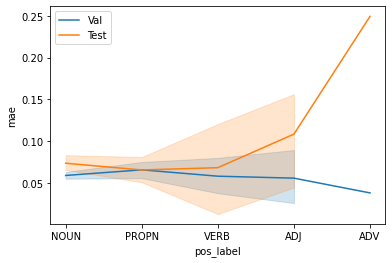

Window size of: 1


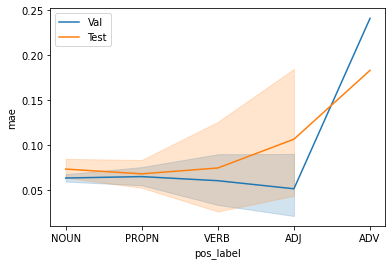

Window size of: 2


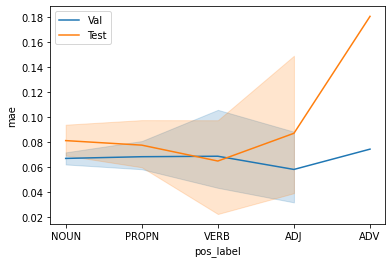

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

for window_ix in results_window:
    print('Window size of:', window_ix)
    sns.lineplot(x='pos_label', y='mae', data=results_window[window_ix].loc[(results_window[window_ix].pos_label.notnull()) &
                                                                           (results_window[window_ix].particion == 'val')], 
                    ci=98, 
                    markers='o')
    sns.lineplot(x='pos_label', y='mae', data=results_window[window_ix].loc[(results_window[window_ix].pos_label.notnull()) &
                                                                           (results_window[window_ix].particion == 'test')], 
                    ci=98, 
                    markers='o')
    plt.legend(['Val', 'Test'])
    plt.show()